In [12]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
##read excel
import pandas as pd
data_path = "/content/drive/MyDrive/sales-prediction/sales.xlsx"
df= pd.read_excel(data_path, engine='openpyxl')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248646 entries, 0 to 248645
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer ID       246741 non-null  object 
 1   Customer Name     248646 non-null  object 
 2   Shipto Name       246741 non-null  object 
 3   Customer PO #     246741 non-null  object 
 4   Delivery Date     248646 non-null  object 
 5   Invoice Number    246741 non-null  object 
 6   Brand             171451 non-null  object 
 7   Item Description  248646 non-null  object 
 8   Itemcode          248646 non-null  int64  
 9   Packsize          171451 non-null  object 
 10  Quantity          248646 non-null  float64
 11  Total Sales       248646 non-null  float64
 12  G/SG              248646 non-null  object 
 13  Gropup            248646 non-null  object 
 14  Group Desc        248646 non-null  object 
 15  Group Name        248646 non-null  object 
 16  Group Name2       24

In [15]:
## filter data

# Convert 'Delivery Date' to datetime
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], errors='coerce')
df = df.dropna(subset=['Delivery Date'])

# Extract the month and year from 'Delivery Date'
df['YearMonth'] = df['Delivery Date'].dt.to_period('M')

current_month = pd.to_datetime('now').to_period('M')

df = df[df['YearMonth'] != current_month]

# Remove trailing whitespace from 'Item Description'
df['Item Description'] = df['Item Description'].str.strip()

# Extracting unique item codes and descriptions
item_dict = df.drop_duplicates(subset=['Itemcode']).set_index('Itemcode')['Item Description'].to_dict()

<ipython-input-15-63b739de287a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearMonth'] = df['Delivery Date'].dt.to_period('M')


In [16]:
# Assuming your DataFrame is named df

# Group by 'YearMonth' and 'Itemcode'
grouped = df.groupby(['YearMonth', 'Itemcode']).agg({
    'Item Description': 'first',
    'Quantity': 'sum',
    'Total Sales': 'sum'
}).reset_index()

# Sort the result by 'YearMonth' and 'Itemcode'
grouped = grouped.sort_values(by=['YearMonth', 'Itemcode'], ascending= False)

grouped

,YearMonth,Itemcode,Item Description,Quantity,Total Sales
3944,2024-09,820013,Turmeric 30 LB,113.0,8155.00
3943,2024-09,810010,Fresh Ginger 20lb,119.0,5593.00
3942,2024-09,810006,Fresh Ginger 10 LB - Box,14300.0,378269.10
3941,2024-09,810002,Turmeric 12x5 OZ.,67.0,1996.00
3940,2024-09,520012,Fresh Ginger 30lb PERU,135.0,5199.00
...,...,...,...,...,...
4,2022-01,110007,Peeled Garlic 30x6 OZ Garland,2074.0,102533.12
3,2022-01,110005,Peeled Garlic 25 LB Commercial,109.0,3325.00
2,2022-01,110004,Peeled Garlic 20x1 LB Garland,152.0,12527.00
1,2022-01,110002,Peeled Garlic 12x3 LB Garland,1353.0,130804.60


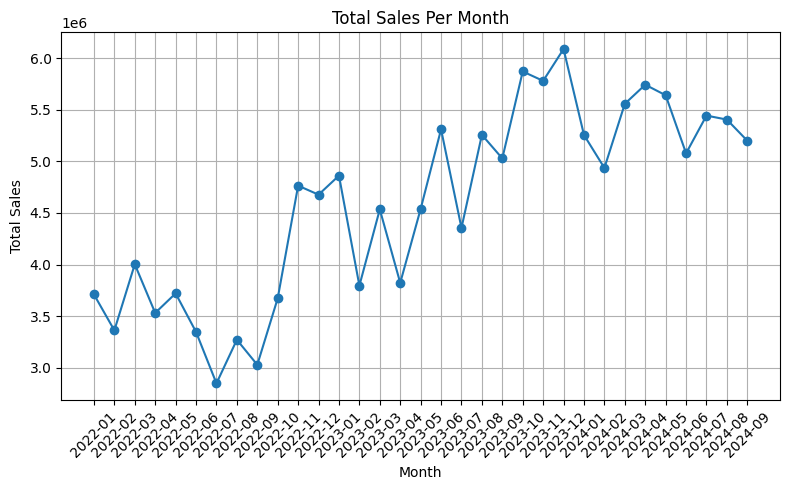

In [17]:
import matplotlib.pyplot as plt

# Group the data by 'YearMonth' and sum the 'Total Sales'
monthly_sales = grouped.groupby('YearMonth')['Total Sales'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(monthly_sales['YearMonth'].astype(str), monthly_sales['Total Sales'], marker='o')

plt.title('Total Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
from sklearn.preprocessing import StandardScaler

## prepare data

# Shift 'Total Sales' to create the y dataset (next total sales)
grouped['YearMonthNumber'] = grouped['YearMonth'].apply(lambda x: x.year * 100 + x.month)
grouped['Next Total Sales'] = grouped.groupby('Itemcode')['Total Sales'].shift(1)
grouped_train = grouped.dropna()


# Extract features to be standardized
features = grouped_train[['Itemcode', 'YearMonthNumber', 'Total Sales']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# Create x and y
x = features_scaled
y = grouped_train['Next Total Sales'].values


print(x.shape)
print(y.shape)


(3689, 3)
(3689,)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Build the model
model = Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(x.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x, y, epochs=300, batch_size=64, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(x, y)
print(f'Model Loss: {loss}')


Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 6605757952.0000 - val_loss: 3025566976.0000
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6831522304.0000 - val_loss: 3025538560.0000
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6918918656.0000 - val_loss: 3025606400.0000
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6810962944.0000 - val_loss: 3025432576.0000
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6102017024.0000 - val_loss: 3025110784.0000
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6491081216.0000 - val_loss: 3024510976.0000
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6483369984.0000 - val_loss: 3023827968.0000
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6427394048.0000 - val_loss: 3023170304.0000
Epoch 9/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7457483776.0000 - val_loss: 3022343168.0000
Epoch 10/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6684246528.0000 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-22-b5361e418201>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows['Predicted Next Sales'] = predicted_next_sales


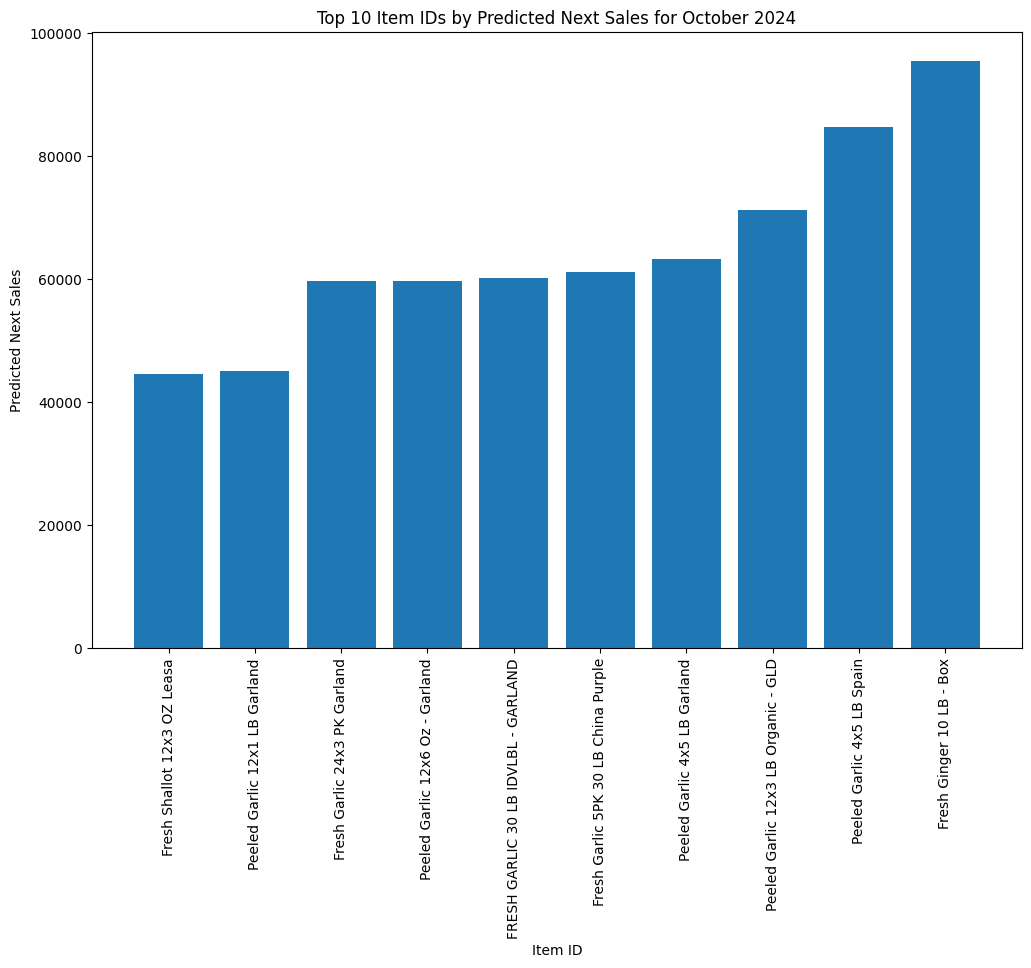

In [22]:


# Define the period
period = pd.Period('2024-9', freq='M')

# Filter the rows for the given period
rows = grouped[grouped['YearMonth'] == period]

# Standardize the features
new_features_scaled = scaler.transform(rows[['Itemcode', 'YearMonthNumber', 'Total Sales']])

# Predict using the trained model
predicted_next_sales = model.predict(new_features_scaled)

# Add predictions to the DataFrame
rows['Predicted Next Sales'] = predicted_next_sales

# Get top 10 Item IDs based on Predicted Next Sales
top_items = rows.nlargest(10, 'Predicted Next Sales')

# Sort by Predicted Next Sales in descending order for the plot
top_items = top_items.sort_values(by='Predicted Next Sales', ascending=True)

# Plot histogram of the top 10 Item IDs
plt.figure(figsize=(12, 8))
plt.bar(top_items['Item Description'].astype(str), top_items['Predicted Next Sales'])
plt.title('Top 10 Item IDs by Predicted Next Sales for October 2024')
plt.xlabel('Item ID')
plt.ylabel('Predicted Next Sales')
plt.xticks(rotation=90, fontsize=10)  # Adjust font size here
plt.show()